In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [2]:
imagePatches = glob('data/ICD/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

data/ICD\10253\0\10253_idx5_x1001_y1001_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1051_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1101_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1151_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1201_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1251_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1301_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1351_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1501_class0.png
data/ICD\10253\0\10253_idx5_x1001_y1551_class0.png


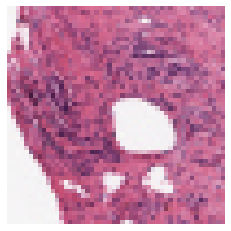

In [3]:
image_name = "data/ICD/8863/0/8863_idx5_x101_y1301_class0.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

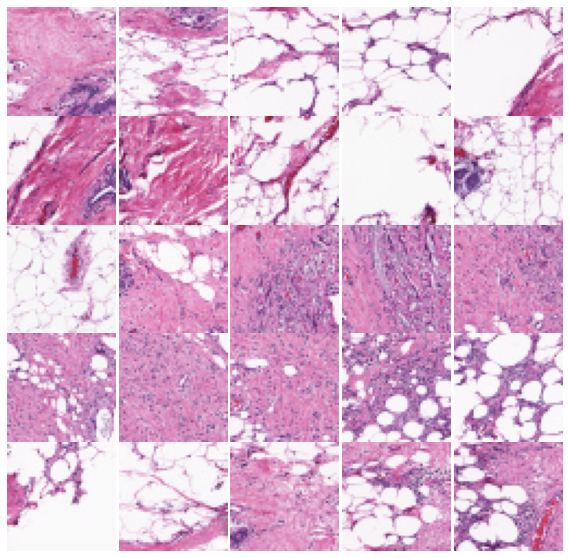

In [3]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

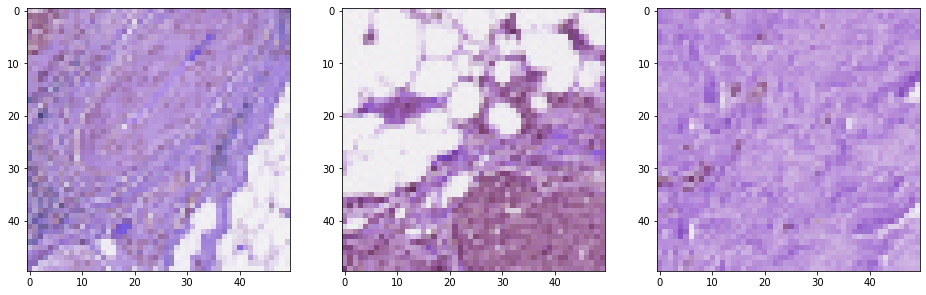

In [4]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
randomImages(imagePatches)

In [5]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("Benign(-)\n\n",classZero[0:5],'\n')
print("Malignant(+)\n\n",classOne[0:5])

Benign(-)

 ['data/ICD\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'data/ICD\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'data/ICD\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'data/ICD\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'data/ICD\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

Malignant(+)

 ['data/ICD\\10253\\1\\10253_idx5_x501_y351_class1.png', 'data/ICD\\10253\\1\\10253_idx5_x501_y401_class1.png', 'data/ICD\\10253\\1\\10253_idx5_x551_y301_class1.png', 'data/ICD\\10253\\1\\10253_idx5_x551_y351_class1.png', 'data/ICD\\10253\\1\\10253_idx5_x551_y401_class1.png']


In [6]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [7]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1]

In [8]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of Benign(-) Images: {}'.format(np.sum(b==0)))
    print('Number of Malignant(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 90000
Number of Benign(-) Images: 64583
Number of Malignant(+) Images: 25417
Percentage of positive images: 28.24%
Image shape (Width, Height, Channels): (50, 50, 3)


In [9]:
dict_characters = {0: 'Benign(-)', 1: 'Malignant(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'Benign(-)', 1: 'Malignant(+)'}


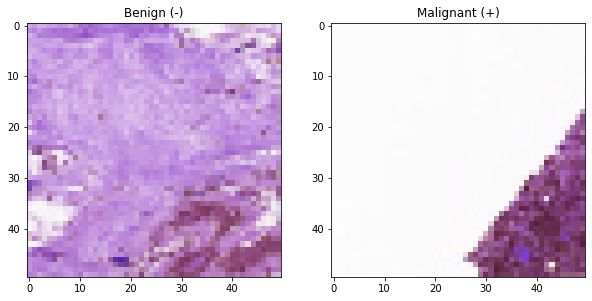

In [10]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('Benign (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('Malignant (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

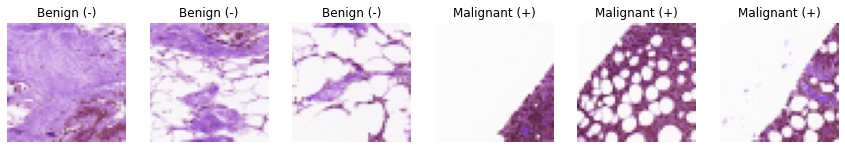

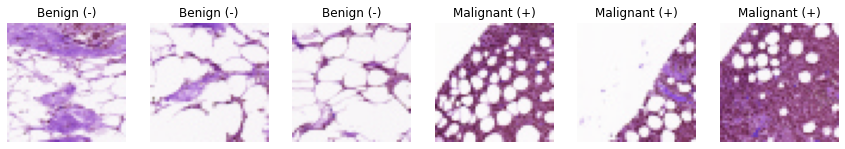

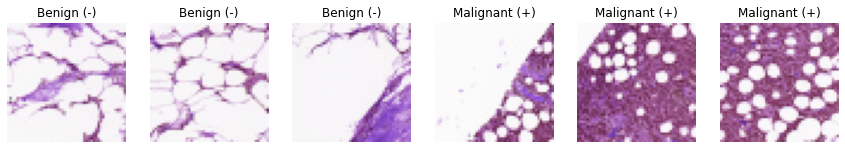

In [11]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('Benign (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('Malignant (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

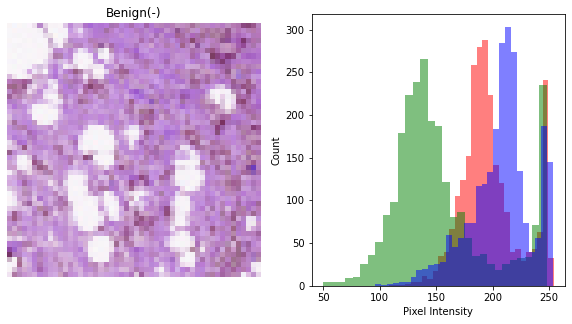

In [12]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('Malignant(+)' if Y[1] else 'Benign(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [13]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (72000, 50, 50, 3)
Testing Data Shape: (18000, 50, 50, 3)


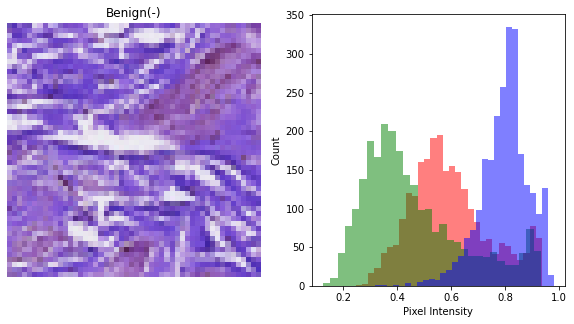

In [14]:
plotHistogram(X_train[100])

In [15]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

C:\Users\magnu\Anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{0: 'Benign(-)', 1: 'Malignant(+)'}


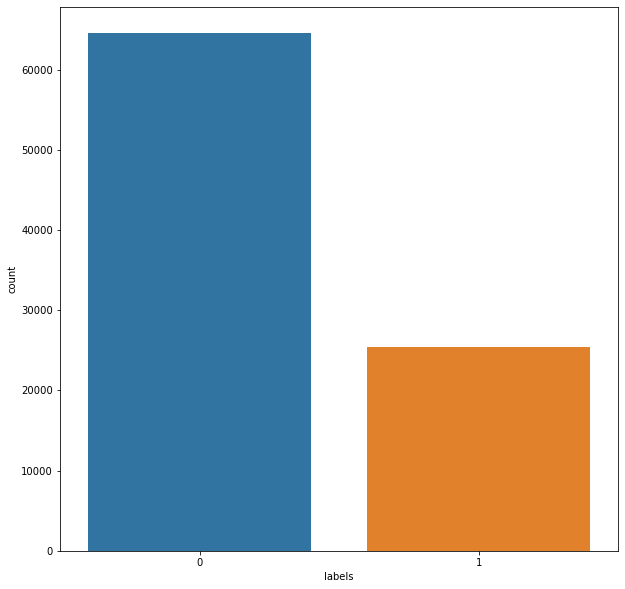

In [17]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

C:\Users\magnu\Anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{0: 'Benign(-)', 1: 'Malignant(+)'}


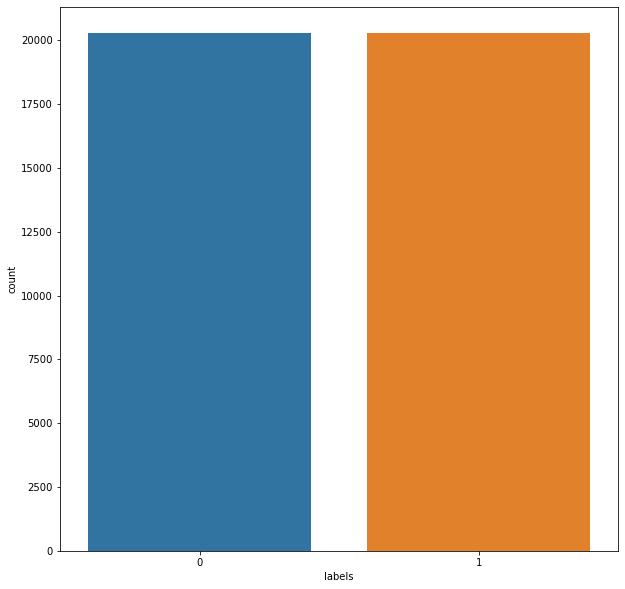

In [18]:

# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = imblearn.over_sampling.RandomOverSampler(ratio='auto', random_state=None)
ros = RandomUnderSampler(sampling_strategy='auto', random_state=None)
#ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [19]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
#print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
#print("New Class Weights: ",class_weight2)

C:\Users\magnu\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 

C:\Users\magnu\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [45]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    acc = history.history['accuracy']
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Epoch 1/12
   3/1268 [..............................] - ETA: 4:06:32 - loss: 1.1547 - accuracy: 0.5000

C:\Users\magnu\Anaconda3\envs\tf\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1269/1268 [==============================] - 159s 125ms/step - loss: 0.5596 - accuracy: 0.7211 - val_loss: 0.5160 - val_accuracy: 0.7431
Epoch 2/12
1269/1268 [==============================] - 123s 97ms/step - loss: 0.4880 - accuracy: 0.7755 - val_loss: 0.4739 - val_accuracy: 0.7818
Epoch 3/12
1269/1268 [==============================] - 119s 93ms/step - loss: 0.4636 - accuracy: 0.7899 - val_loss: 0.4324 - val_accuracy: 0.8060
Epoch 4/12
1269/1268 [==============================] - 116s 91ms/step - loss: 0.4454 - accuracy: 0.8009 - val_loss: 0.3969 - val_accuracy: 0.8248
Epoch 5/12
1269/1268 [==============================] - 116s 92ms/step - loss: 0.4331 - accuracy: 0.8071 - val_loss: 0.4286 - val_accuracy: 0.8115
Epoch 6/12
1269/1268 [==============================] - 117s 92ms/step - loss: 0.4250 - accuracy: 0.8118 - val_loss: 0.3908 - val_accuracy: 0.8268
Epoch 7/12
1269/1268 [==============================] - 115s 91ms/step - loss: 0.4217 - accuracy: 0.8127 - val_loss: 0.3832 - va

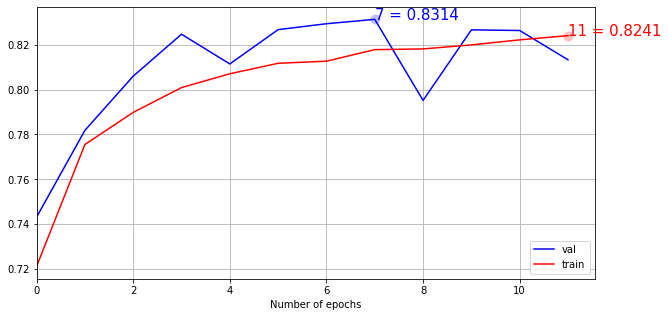

KeyError: 'acc'

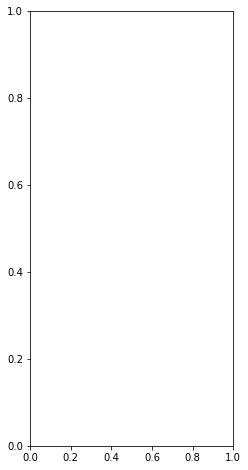

In [50]:
def runKerasCNNAugment(a,b,c,d,e,f):
    
    batch_size = 128
    num_classes = 2
    epochs = 12
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
   
    
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    model.save_weights('model_weights.h5')
    model.save('model_keras.h5')
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'Benign(-)', 1: 'Malignant(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
    
    
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)



In [51]:
from keras.preprocessing import image
from IPython.display import Image

In [52]:
classifier = keras.models.load_model('model_keras.h5',)

In [54]:
classifier.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               991360    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)             

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               4333696   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

In [60]:
x_test = X[0:10]
x = np.array(x_test)
test_datagen = ImageDataGenerator(rescale=1./255)



In [70]:
def testing(c,d):
    test_data = c[0:10]
    y_pred = classifier.predict(tets_data)
    map_characters = {0: 'Benign(-)', 1: 'Malignant(+)'}
    if map_characters == 0:
        prediction = 'benign'
    else:
        prediction = 'malignant'

#print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 